## IMPORT LIBRARY

In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import numpy as np
import random
import gradio as gr

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import timm
import torch
from torchvision import transforms, datasets

from torch import nn, optim
from torchvision import datasets, models, transforms
from torchvision.models import vgg16
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

## EDA

In [2]:
base_path = r"dataset\train"
folders= {
    "Batik Bali":"Batik Bali",
    "Batik Betawi":"Batik Betawi",
    "Batik Cendrawasih": "Batik Cendrawasih",
    "Batik Dayak": "Batik Dayak",
    "Batik Geblek Renteng":"Batik Geblek Renteng",
    "Batik Ikat Celup":"Batik Ikat Celup",
    "Batik Insang":"Batik Insang",
    "Batik Kawung":"Batik Kawung",
    "Batik Lasem":"Batik Lasem",
    "Batik Megamendung":"Batik Megamendung",
    "Batik Pala":"Batik Pala",
    "Batik Parang":"Batik Parang",
    "Batik Poleng":"Batik Poleng",
    "Batik Sekar Jagad":"Batik Sekar Jagad",
    "Batik Tambal":"Batik Tambal"
}

In [3]:
folder_counts = {}
total_images = 0
for name, folder in folders.items():
    path = os.path.join(base_path, folder)
    count = len([f for f in os.listdir(path) if f.endswith(('.png', '.jpg', '.jpeg'))])  # Filter gambar
    folder_counts[name] = count
    total_images += count
print("Jumlah Gambar per Folder:")
for name, count in folder_counts.items():
    print(f"{name}: {count} gambar")
print(f"Total: {total_images} gambar\n")

Jumlah Gambar per Folder:
Batik Bali: 70 gambar
Batik Betawi: 70 gambar
Batik Cendrawasih: 70 gambar
Batik Dayak: 70 gambar
Batik Geblek Renteng: 70 gambar
Batik Ikat Celup: 70 gambar
Batik Insang: 70 gambar
Batik Kawung: 70 gambar
Batik Lasem: 70 gambar
Batik Megamendung: 70 gambar
Batik Pala: 70 gambar
Batik Parang: 70 gambar
Batik Poleng: 70 gambar
Batik Sekar Jagad: 70 gambar
Batik Tambal: 70 gambar
Total: 1050 gambar



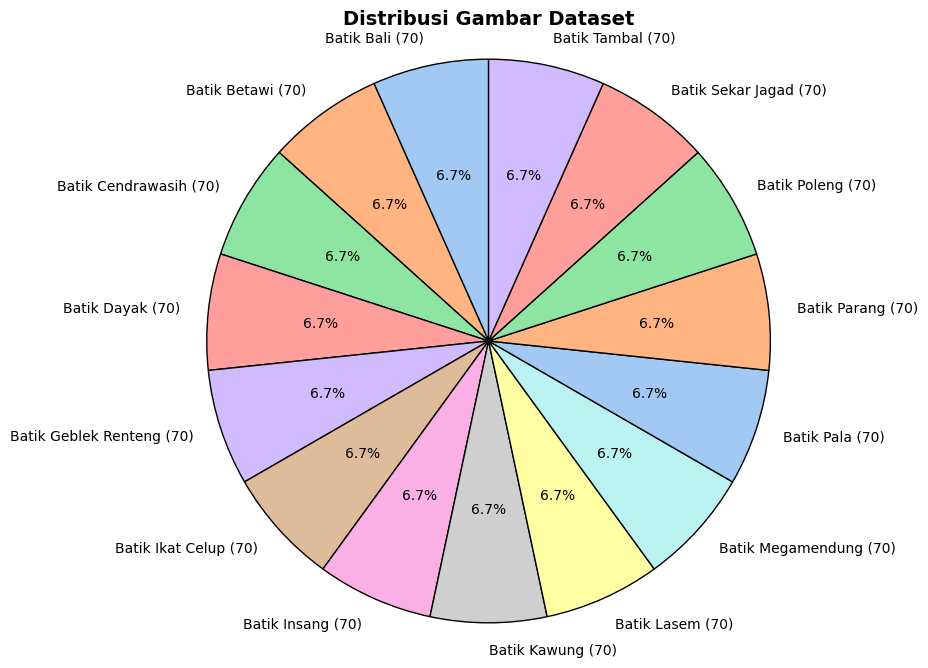

In [4]:
colors = sns.color_palette("pastel")  # Bisa diganti dengan "deep", "muted", dll.

labels = [f"{name} ({count})" for name, count in folder_counts.items()]
sizes = list(folder_counts.values())

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, 
        wedgeprops={'edgecolor': 'black', 'linewidth': 1})  # Memberikan outline pada setiap bagian

plt.title("Distribusi Gambar Dataset", fontsize=14, fontweight='bold')
plt.axis('equal')  # Memastikan pie chart tetap berbentuk lingkaran

plt.show()

In [5]:
base_path = r"dataset\test"
folder_counts = {}
total_images = 0
for name, folder in folders.items():
    path = os.path.join(base_path, folder)
    count = len([f for f in os.listdir(path) if f.endswith(('.png', '.jpg', '.jpeg'))])  # Filter gambar
    folder_counts[name] = count
    total_images += count
print("Jumlah Gambar per Folder:")
for name, count in folder_counts.items():
    print(f"{name}: {count} gambar")
print(f"Total: {total_images} gambar\n")

Jumlah Gambar per Folder:
Batik Bali: 20 gambar
Batik Betawi: 20 gambar
Batik Cendrawasih: 20 gambar
Batik Dayak: 20 gambar
Batik Geblek Renteng: 20 gambar
Batik Ikat Celup: 20 gambar
Batik Insang: 20 gambar
Batik Kawung: 20 gambar
Batik Lasem: 20 gambar
Batik Megamendung: 20 gambar
Batik Pala: 20 gambar
Batik Parang: 20 gambar
Batik Poleng: 20 gambar
Batik Sekar Jagad: 20 gambar
Batik Tambal: 20 gambar
Total: 300 gambar



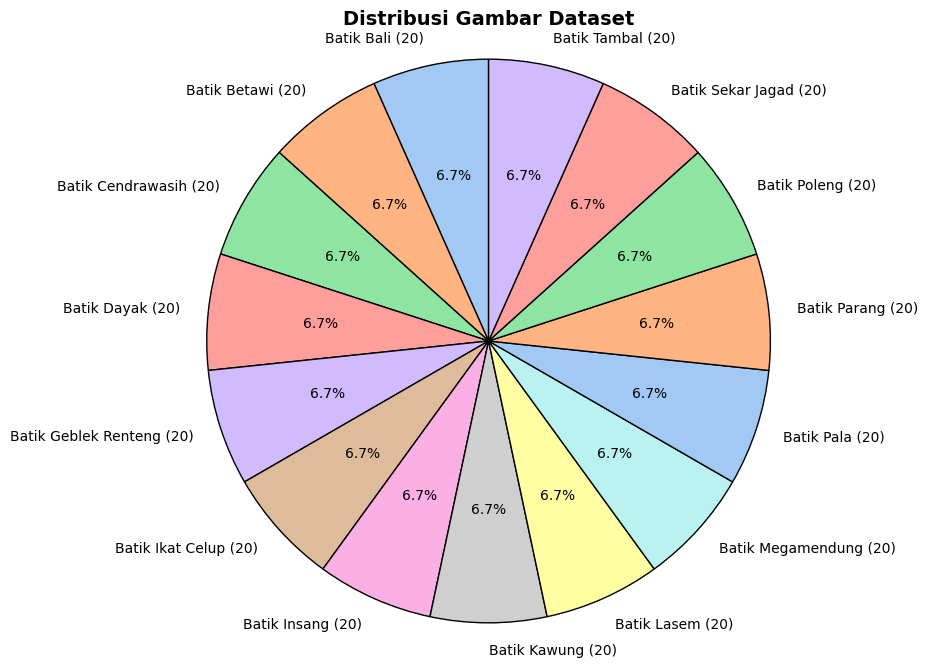

In [6]:
colors = sns.color_palette("pastel")  # Bisa diganti dengan "deep", "muted", dll.

labels = [f"{name} ({count})" for name, count in folder_counts.items()]
sizes = list(folder_counts.values())

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, 
        wedgeprops={'edgecolor': 'black', 'linewidth': 1})  # Memberikan outline pada setiap bagian

plt.title("Distribusi Gambar Dataset", fontsize=14, fontweight='bold')
plt.axis('equal')  # Memastikan pie chart tetap berbentuk lingkaran

plt.show()

Train = 76%
Test = 24%

In [7]:
data = []

for category in os.listdir(r"dataset\train"):
    category_path = os.path.join(r"dataset\train", category)

    if os.path.isdir(category_path):
        for img_file in os.listdir(category_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                full_img_path = os.path.join(category_path, img_file)
                
                try:
                    with Image.open(full_img_path) as img:
                        # Konversi ke numpy array
                        img_array = np.array(img)

                        # Dapatkan ukuran gambar
                        width, height = img.size
                        channels = 1 if len(img_array.shape) == 2 else img_array.shape[2]

                        # Hitung intensitas rata-rata
                        avg_intensity = img_array.mean()

                        data.append({
                            "image_path": full_img_path,
                            "category": category,
                            "width": width,
                            "height": height,
                            "aspect_ratio": round(width / height, 2),
                            "channels": channels,
                            "avg_intensity": round(avg_intensity, 2)
                        })
                except Exception as e:
                    print(f"Gagal memproses gambar {full_img_path}: {e}")


In [8]:
# Buat DataFrame
df = pd.DataFrame(data)

# Tampilkan beberapa data
(df.head())

,image_path,category,width,height,aspect_ratio,channels,avg_intensity
0,dataset\train\Batik Bali\0.jpg,Batik Bali,224,224,1.0,3,108.88
1,dataset\train\Batik Bali\1.jpg,Batik Bali,224,224,1.0,3,147.77
2,dataset\train\Batik Bali\10.jpg,Batik Bali,224,224,1.0,3,104.28
3,dataset\train\Batik Bali\11.jpg,Batik Bali,224,224,1.0,3,127.69
4,dataset\train\Batik Bali\12.jpg,Batik Bali,224,224,1.0,3,101.42


In [9]:
def categorize_intensity(val):
    if val < 86:
        return 'gelap'
    elif val < 171:
        return 'sedang'
    else:
        return 'terang'

df['intensity_category'] = df['avg_intensity'].apply(categorize_intensity)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   image_path          1050 non-null   object 
 1   category            1050 non-null   object 
 2   width               1050 non-null   int64  
 3   height              1050 non-null   int64  
 4   aspect_ratio        1050 non-null   float64
 5   channels            1050 non-null   int64  
 6   avg_intensity       1050 non-null   float64
 7   intensity_category  1050 non-null   object 
dtypes: float64(2), int64(3), object(3)
memory usage: 65.8+ KB


In [11]:
df.category.unique()

array(['Batik Bali', 'Batik Betawi', 'Batik Cendrawasih', 'Batik Dayak',
       'Batik Geblek Renteng', 'Batik Ikat Celup', 'Batik Insang',
       'Batik Kawung', 'Batik Lasem', 'Batik Megamendung', 'Batik Pala',
       'Batik Parang', 'Batik Poleng', 'Batik Sekar Jagad',
       'Batik Tambal'], dtype=object)

In [12]:
numerical_feature = df.select_dtypes(include=['float64', 'int64'])

In [13]:
numerical_feature.describe()

,width,height,aspect_ratio,channels,avg_intensity
count,1050.0,1050.0,1050.0,1050.0,1050.000000
mean,224.0,224.0,1.0,3.0,117.427181
std,0.0,0.0,0.0,0.0,31.405748
min,224.0,224.0,1.0,3.0,28.010000
25%,224.0,224.0,1.0,3.0,96.842500
50%,224.0,224.0,1.0,3.0,113.485000
75%,224.0,224.0,1.0,3.0,134.082500
max,224.0,224.0,1.0,3.0,240.470000


In [14]:
df['intensity_category'].value_counts()

intensity_category
sedang    835
gelap     140
terang     75
Name: count, dtype: int64

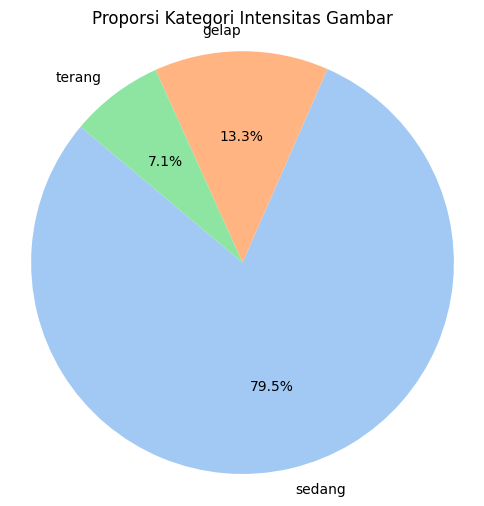

In [15]:
# Hitung jumlah per kategori
intensity_counts = df['intensity_category'].value_counts()

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    intensity_counts,
    labels=intensity_counts.index,
    autopct='%1.1f%%',
    colors=sns.color_palette('pastel'),
    startangle=140
)

plt.title('Proporsi Kategori Intensitas Gambar')
plt.axis('equal')  # lingkaran sempurna
plt.show()

In [16]:
df[df['avg_intensity'] < 86]

,image_path,category,width,height,aspect_ratio,channels,avg_intensity,intensity_category
9,dataset\train\Batik Bali\17.jpg,Batik Bali,224,224,1.0,3,79.97,gelap
12,dataset\train\Batik Bali\2.jpg,Batik Bali,224,224,1.0,3,82.01,gelap
19,dataset\train\Batik Bali\26.jpg,Batik Bali,224,224,1.0,3,77.59,gelap
21,dataset\train\Batik Bali\28.jpg,Batik Bali,224,224,1.0,3,84.45,gelap
29,dataset\train\Batik Bali\35.jpg,Batik Bali,224,224,1.0,3,82.20,gelap
...,...,...,...,...,...,...,...,...
1043,dataset\train\Batik Tambal\66.jpg,Batik Tambal,224,224,1.0,3,71.13,gelap
1044,dataset\train\Batik Tambal\67.jpg,Batik Tambal,224,224,1.0,3,81.48,gelap
1045,dataset\train\Batik Tambal\68.jpg,Batik Tambal,224,224,1.0,3,55.33,gelap
1047,dataset\train\Batik Tambal\7.jpg,Batik Tambal,224,224,1.0,3,76.74,gelap


In [17]:
# Fungsi untuk menampilkan satu gambar dari kategori tertentu
def tampil_gambar_kategori(df, kategori):
    df_kategori = df[df['intensity_category'] == kategori]
    if df_kategori.empty:
        print(f"Tidak ada gambar dengan kategori: {kategori}")
        return
    sample = df_kategori.sample(1).iloc[0]
    img = Image.open(sample['image_path'])

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{kategori.upper()} | Intensitas: {sample['avg_intensity']}")
    plt.show()

# 1. Gambar gelap
def tampil_gambar_gelap():
    tampil_gambar_kategori(df, 'gelap')

# 2. Gambar sedang
def tampil_gambar_sedang():
    tampil_gambar_kategori(df, 'sedang')

# 3. Gambar terang
def tampil_gambar_terang():
    tampil_gambar_kategori(df, 'terang')

# 4. Perbandingan gelap vs sedang vs terang
def tampil_perbandingan():
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    kategori_list = ['gelap', 'sedang', 'terang']

    for i, kategori in enumerate(kategori_list):
        df_kat = df[df['intensity_category'] == kategori]
        if df_kat.empty:
            axs[i].set_title(f"Tidak ada data: {kategori}")
            axs[i].axis('off')
            continue
        sample = df_kat.sample(1).iloc[0]
        img = Image.open(sample['image_path'])
        axs[i].imshow(img)
        axs[i].set_title(f"{kategori.upper()} ({sample['avg_intensity']:.1f})")
        axs[i].axis('off')

    plt.suptitle("Perbandingan Gambar: Gelap vs Sedang vs Terang")
    plt.tight_layout()
    plt.show()


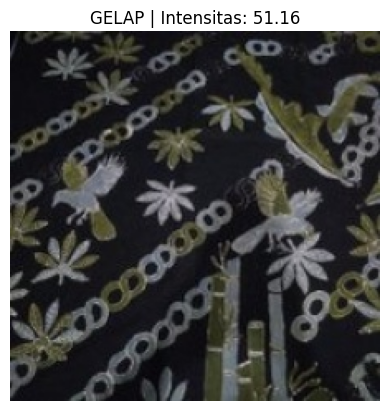

In [18]:
tampil_gambar_gelap()

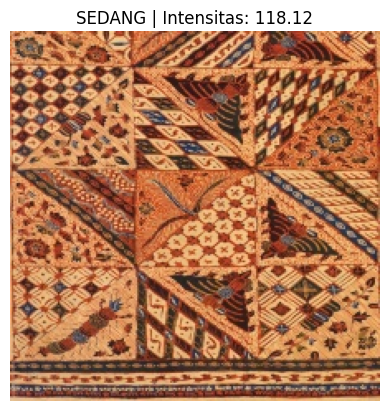

In [19]:
tampil_gambar_sedang()

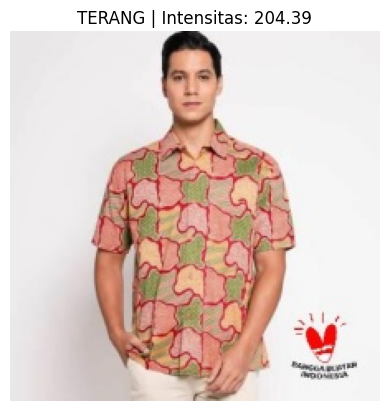

In [20]:
tampil_gambar_terang()

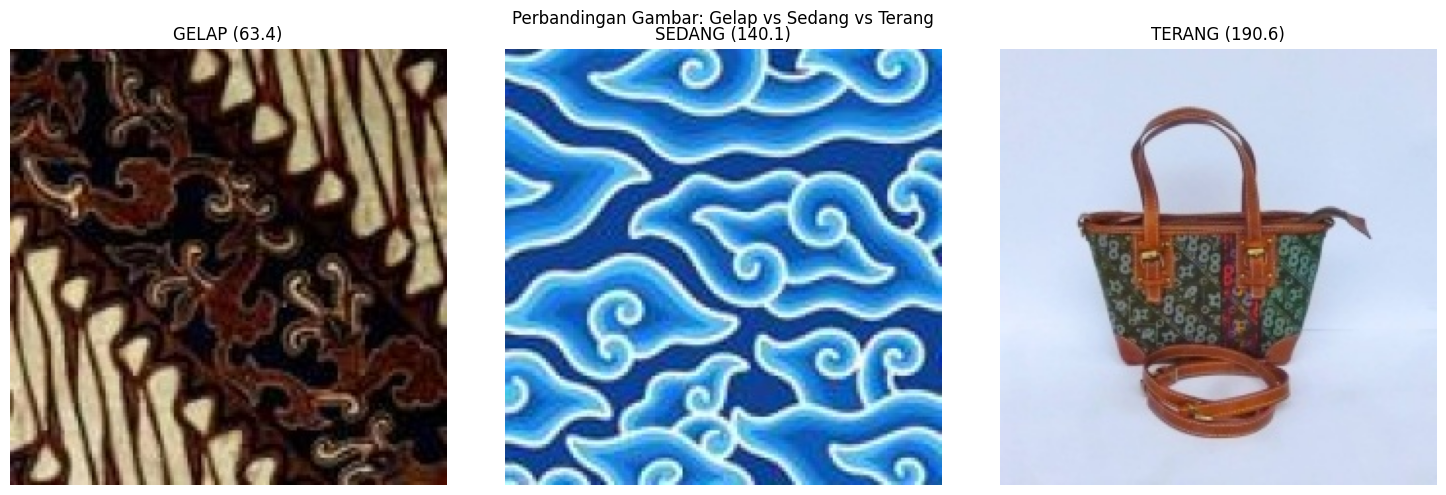

In [21]:
tampil_perbandingan()

## PREPROCESSING DAN AUGMENTASI

In [22]:
data_dir = "./dataset/"

# Transformasi untuk train dan test
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

In [23]:
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform_train)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
print(f"Kelas Batik: {class_names}")

Kelas Batik: ['Batik Bali', 'Batik Betawi', 'Batik Cendrawasih', 'Batik Dayak', 'Batik Geblek Renteng', 'Batik Ikat Celup', 'Batik Insang', 'Batik Kawung', 'Batik Lasem', 'Batik Megamendung', 'Batik Pala', 'Batik Parang', 'Batik Poleng', 'Batik Sekar Jagad', 'Batik Tambal']


In [24]:
print(len(class_names))

15


## MODELLING

### LOAD PRETRAINED EFFICIENTNET

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],   # rata‑rata per channel
        std=[0.5, 0.5, 0.5]     # deviasi standar per channel
    )
])

In [27]:
train_dataset = datasets.ImageFolder('dataset/train', transform=transform)
train_loader  = DataLoader(train_dataset, batch_size=32, shuffle=True)
class_names   = train_dataset.classes  # list label
num_classes   = len(class_names)

In [28]:
# 2. Load pretrained ViT
model = timm.create_model('vit_base_patch16_224', pretrained=True)

In [29]:
# 3. Freeze semua parameter kecuali head (classifier)
for name, param in model.named_parameters():
    # parameter head di ViT biasanya di 'head' atau 'head.fc'
    if not name.startswith('head'):
        param.requires_grad = False

In [30]:
# 4. Ganti head/classifier
#    Pada timm ViT, head adalah Linear di model.head
in_features = model.head.in_features
model.head = nn.Linear(in_features, num_classes)

In [31]:
model = model.to(device)

### TRAIN MODEL

In [32]:
# 5. Loss & optimizer (hanya train head)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.head.parameters(), lr=1e-3)

In [ ]:
epochs = 100
train_losses, train_accuracies = [], []

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = total_loss / len(train_loader)
    epoch_acc  = correct / total * 100
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Akurasi: {epoch_acc:.2f}%")

## EVALUASI MODEL

**SKOR AKURASI**

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Akurasi Pengujian: {correct / total * 100:.2f}%")

**VISUALISASI LOSS DAN AKURASI**

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, 'r-o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, 'b-o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)

plt.tight_layout()
plt.show()


### CLASSIFICATION REPORT

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Evaluasi
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
rec = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Akurasi:  {acc:.4f}")
print(f"Presisi:  {prec:.4f}")
print(f"Recall:   {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

# Optional: lihat laporan per kelas
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))


## PREDICT IMAGE

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
def predict_batik(image):
    image = image.convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
        class_idx = predicted.item()
        confidence = torch.nn.functional.softmax(outputs, dim=1)[0][class_idx].item()

    return f"{class_names[class_idx]} (Confidence: {confidence:.2%})"

In [ ]:
gr.Interface(
    fn=predict_batik,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Klasifikasi Gambar Batik",
    description="Upload gambar batik untuk mengetahui jenisnya"
).launch()


In [ ]:
def predict_batik(image):
    image = image.convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
        class_idx = predicted.item()
        confidence = torch.nn.functional.softmax(outputs, dim=1)[0][class_idx].item()

    return f"{class_names[class_idx]} (Confidence: {confidence:.2%})"

def display_random_test_images(base_test_path, num_images=6):
    # Mendapatkan semua jalur gambar dari folder test
    image_paths = []
    true_labels = []
    
    for folder in os.listdir(base_test_path):
        folder_path = os.path.join(base_test_path, folder)
        if os.path.isdir(folder_path):
            for img_name in os.listdir(folder_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(folder_path, img_name))
                    true_labels.append(folder)
    
    # Memilih 6 indeks acak
    selected_indices = random.sample(range(len(image_paths)), min(num_images, len(image_paths)))
    
    # Mengatur tampilan plot
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, img_idx in enumerate(selected_indices):
        # Memuat gambar
        img_path = image_paths[img_idx]
        true_label = true_labels[img_idx]
        image = Image.open(img_path)
        
        # Memprediksi jenis batik
        prediction = predict_batik(image)
        predicted_label = prediction.split(" (Confidence")[0]
        
        # Menentukan warna teks berdasarkan kebenaran prediksi
        text_color = "green" if predicted_label == true_label else "red"
        
        # Menampilkan gambar
        axes[idx].imshow(image)
        axes[idx].axis('off')
        axes[idx].set_title(f"True: {true_label}\nPred: {prediction}", color=text_color, fontsize=10)
    
    plt.tight_layout()
    plt.show()

In [ ]:
base_test_path = "./dataset/test"
display_random_test_images(base_test_path)

In [ ]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# ROC AUC Curve
model.eval()
all_probs = []
all_labels_roc = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)  # Konversi output ke probabilitas
        all_probs.extend(probs.cpu().numpy())
        all_labels_roc.extend(labels.cpu().numpy())

all_probs = np.array(all_probs)
all_labels_roc = np.array(all_labels_roc)

# Binarize labels untuk multi-class ROC
n_classes = len(class_names)
y_test_bin = label_binarize(all_labels_roc, classes=range(n_classes))

# Hitung ROC untuk setiap kelas
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange']  # Sesuaikan dengan jumlah kelas
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2,
             label=f'ROC curve kelas {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Garis diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
# Hitung AUC rata-rata (macro)
roc_auc_macro = roc_auc_score(y_test_bin, all_probs, average='macro')
print(f"Macro-Average ROC AUC Score: {roc_auc_macro:.4f}")